<!-- KODE = "ja", "nei", default "ja" -->

<!-- dom:TITLE: Numerical solution of ordinary differential equations  -->
# Numerical solution of ordinary differential equations 
<!-- dom:AUTHOR: Anne Kværnø -->
<!-- Author: -->  
**Anne Kværnø**

Date: **Feb 18, 2022**

$\newcommand{mb}[1]{\mathbf{#1}}$

In [26]:
%matplotlib inline

import numpy as np
from numpy.linalg import solve, norm    # Solve linear systems and compute norms
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

If you want to have a nicer theme for your jupyter notebook,
download the [cascade stylesheet file tma4320.css](https://www.math.ntnu.no/emner/TMA4320/2022v/notebooks/tma4320.css)
and execute the next cell:

In [27]:
from IPython.core.display import HTML
def css_styling():
    styles = open("tma4320.css", "r").read()
    return HTML(styles)

# Comment out next line and execute this cell to restore the default notebook style 
css_styling();

# Introduction
The topic of this note is the numerical solution of systems of ordinary differential
equations (ODEs). This has been discussed in previous courses, see for instance
the webpage 
[Differensialligninger](https://wiki.math.ntnu.no/tma4100/tema/differentialequations)
from Mathematics 1. 

### Scalar ODEs

A scalar ODE is an equation of the form

$$
y'(x) = f(x,y(x)), \qquad y(x_0)=y_0,
$$

where $y'(x)=\frac{dy}{dx}$. The *inital condition* $y(x_0)=y_0$ is required for a unique
solution. 

**NB!** It is common to use the term *initial value problem (IVP)* for an ODE for which the inital value $y(x_0)=y_0$ is given, and we only are interested in the solution for $x>x_0$. In this note, only initial value problems are considered.  

**Example 1:** 
The general solution of the ODE

$$
y'(x) = -2xy(x)
$$

is the function

$$
y(x) = C e^{-x^2},
$$

where $C$ is a constant that depends on the initial condition $y(x_0)$.
For instance, we obtain for $x_0 = 0$ and $y(0) = 1$ the solution

$$
y(x) = e^{-x^2},
$$

### Systems of ODEs

A system of $m$ ODEs is given by

$$
\begin{align*}
y_1' &= f_1(x,y_1,y_2,\dotsc,y_m), & y_1(x_0) &= y_{1,0} \\ 
y_2' &= f_2(x,y_1,y_2,\dotsc,y_m), & y_2(x_0) &= y_{2,0} \\ 
     &\ \vdots                      &          &\vdots    \\ 
y_m' &= f_m(x,y_1,y_2,\dotsc,y_m), & y_m(x_0) &= y_{m,0} \\ 
\end{align*}
$$

or, more compactly, by

$$
\mb{y}'(x) = \mb{f}(x, \mb{y}(x)),  \qquad \mb{y}(x_0) = \mb{y}_0
$$

where we use boldface to denote vectors in $\mathbb{R}^m$.

$$
\mb{y}(x) = \left( \begin{array}{c} y_1(x) \\ y_2(x) \\ \vdots \\ y_m(x) \end{array} \right), \qquad
\mb{f}(x,\mb{y}) = \left( \begin{array}{c} f_1(x,y_1,y_2,\dotsc,y_m), \\ f_2(x,y_1,y_2,\dotsc,y_m), \\ \vdots \\ f_m(x,y_1,y_2,\dotsc,y_m), \end{array} \right), \qquad
\mb{y}_0 = \left( \begin{array}{c} y_{1,0} \\ y_{2,0} \\ \vdots \\ y_{m,0} \end{array} \right),
$$

**Example 2:**
[The Lotka-Volterra equation](https://en.wikipedia.org/wiki/Lotka–Volterra_equations) is a system of two ODEs describing the interaction between predators and prey over time. The system is given as

$$
\begin{align*}
y'(x) &= \alpha y(x) - \beta y(x) z(x), \\ 
z'(x) &= \delta y(x)z(x) - \gamma z(x).
\end{align*}
$$

Here $x$ denotes time, $y(x)$ describes the population of the prey species, and $z(x)$ the population of predators. 
The parameters $\alpha$, $\beta$, $\delta$, and $\gamma$ depend on the populations to be modelled.  

### Autonomous ODEs

An ODE is called \emph{autonomous }if $\mb{f}$ is not a function of $x$,
but only of $\mb{y}$. The Lotka-Volterra equation is an example of an
autonomous ODE. A nonautonomous system can be made autonomous by a
simple trick, just add the equation

$$
y_{m+1}'=1,\qquad y_{m+1}(x_{0})=x_{0},
$$

and replace $t$ with $y_{m+1}$. 

### Higher order ODEs

An initial value  ODE of order $m$ is given by

$$
u^{(m)} = f(x,u,u',\dotsc,u^{(m-1)}), \qquad u(x_0)=u_0, \quad
u'(x_0)=u'_0,\quad  \dotsc, \quad u^{(m-1)}(x_0) = u^{(m-1)}_0.
$$

Here $u^{(1)} =u'$ and $u^{(m+1)}=\frac{du^{(m)}}{dx}$ for $m>0$.

**Example 3:**

[Van der Pol's equation](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator)
is a second order differential equation, given by

$$
u^{(2)} = \mu (1-u^2)u' - u, \qquad u(0)=u_0, \quad u'(0)=u'_0,
$$

where $\mu>0$ is some constant.  Common choices for initial values are $u_0=2$ and $u'_0=0$.

Later in the note we will see how such equations can be rewritten as a system of first order ODEs. 
Systems of higher order ODEs can be treated similarly.  


# Numerical methods for solving ODEs
In this note, we will discuss some techniques for the numerial solution
of ordinary differential equations. For simplicity or presentation,
we will develop and discuss these methods mostly based on scalar ODEs.
The same methods, however, are equally applicable for systems of equations.

All the methods that we will discuss are so-called *one-step methods*.
Given the ODE and the initial values $(x_0,y_0)$, 
we choose some step size $h$ and let $x_1=x_0+h$. Based on this information,
we calculate an approximation $y_1$ to $y(x_1)$.
Then, we repeat this process starting from $(x_1,y_1)$
in order to calculate an approximation $y_2$ of $y(x_2)$, where $x_2 = x_1 + h$.
This process is repeated until some final point, here called $x_{end}$ is reached. 

In one-step methods, the approximation $y_{k+1}$ of $y(x_{k+1})$ does not depend
on the values of $y_{k-1}$, $y_{k-2}$, \ldots, $y_0$.
The main alternative to this type of methods are *multi-step methods*,
where the approximation $y_{k+1}$ of $y(x_{k+1})$ takes into account those
values as well.

It should be emphasized that this strategy only will find approximations to the
exact solution in some discrete points $x_n$, $n=0,1,\ldots$. 


# Euler's method
Let us start with the simplest example, [Euler's method](https://wiki.math.ntnu.no/tma4100/tema/differentialequations?&#numeriske_losninger), known from Mathematics 1. 

We are given an IVP

$$
y'(x) = f(x,y(x)), \qquad y(x_0)=y_0.
$$

Choose some step size $h$. The trick is as follows: 

Do a Taylor expansion (*Preliminaries*, section 4) of the exact (but unknown) solution $y(x_0+h)$ around $x_0$:

$$
y(x_0+h) = y(x_0) + h y'(x_0) + \frac{1}{2}h^2 y''(x_0) + \dotsm.
$$

Assume the step size $h$ to be small, such that the solution is dominated by the first two terms.  In that case, these can be used as the numerical approximation in the next step:

$$
y(x_0+h) \approx  y(x_0) + h y'(x_0) = y_0 + hf(x_0, y_0)
$$

giving

$$
y_1 = y_0 + hf(x_0,y_0).
$$

Repeating this, results in 
**Euler's method.**

* Given a function $f(x,y)$ and an initial value $(x_0,y_0)$.

* Choose a step size $h$. 

* For $i=0,1,2,\dotsc$ 

  * $\displaystyle y_{n+1}  = y_{n} + h f(x_n, y_n)$, 

  * $x_{n+1}=x_n+h$.



# Implementation
We would like to make this implementation more like a test platform. It should
be simple to implement and test methods other than Euler's. That is why the
implementaion here is divided in two parts:

* `ode_solver`: This is a generic solver, and can be used by other methods than Euler's. 

* `euler`:      This function performs one step of Euler's method.

In [28]:
def euler(f, x, y, h):
    # One step of the Euler method
    y_next = y + h*f(x, y)
    x_next = x + h
    return x_next, y_next

In [29]:
def ode_solver(f, x0, xend, y0, h, method=euler):
    '''
    Generic solver for ODEs
        y' = f(x,y), y(a)=y0
    Input: f, the integration interval x0 and xend, 
           the stepsize h and the method of choice.  
       
    Output: Arrays with the x- and the corresponding y-values. 
    '''

    #Initializing:
    y_num = np.array([y0])    # Array for the solution y 
    x_num = np.array([x0])    # Array for the x-values

    xn = x0                # Running values for x and y
    yn = y0 

    # Main loop
    while xn < xend - 1.e-10:            # Buffer for truncation errors        
        xn, yn = method(f, xn, yn, h)    # Do one step by the method of choice
        
        # Extend the arrays for x and y
        y_num = np.concatenate((y_num, np.array([yn])))
        x_num = np.append(x_num,xn)
        
    return x_num, y_num

The function `method`, which performs one step with a given method, can be changed, but the call of the function has to be of the following form:

`x_next, y_next = method(f, x, y, h)`. 


**Numerical example 1:**
Test the implementation of Euler's method on the problem

$$
y'(x) = -2xy(x), \qquad y(0)=1, \qquad 0 \leq x \leq 1,
$$

which has the analytic solution

$$
y(x) = e^{-x^2}.
$$

Try with different step sizes, for instance $h=0.1$, $h=0.05$ and $h=0.01$. In
each case, compare the numerical solution with the exact one. 

The following script solves the equation numerically.

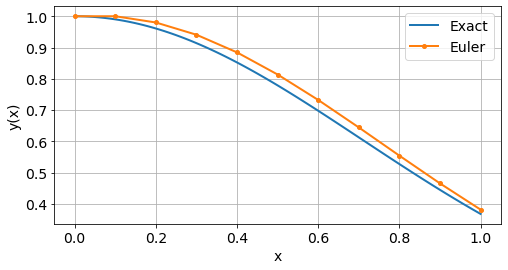

In [30]:
# Numerical experiment 1

# The right hand side of the ODE
def f(x, y):
    return -2*x*y

# The exact solution, for verification
def y_exact(x):
    return np.exp(-x**2)

x0, xend = 0, 1               # Integration interval
y0 = 1                        # Initial value for y
h = 0.1                       # Stepsize

# Solve the equation
x_num, y_num = ode_solver(f, x0, xend, y0, h)

# Plot of the exact solution
x = np.linspace(x0, xend, 101)
plt.plot(x, y_exact(x))

# Plot of the numerical solution
plt.plot(x_num, y_num, '.-')

plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend(['Exact', 'Euler']);

We can also make a plot of the error in each step:

Max error =  3.480e-02


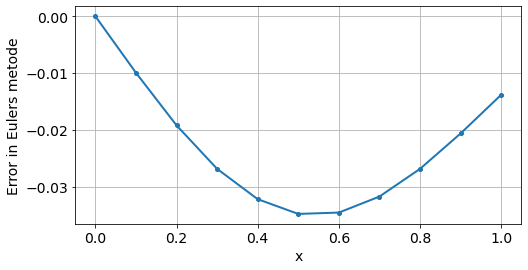

In [31]:
# Calculate and plot the error in the x-values
error = y_exact(x_num)-y_num
plt.plot(x_num, error, '.-')
plt.xlabel('x')
plt.ylabel('Error in Eulers metode')
print(f'Max error =  {max(abs(error)):.3e}')  # Print the maximum error

**Numerical exercise 1:**
Repeat the example on a [logistic
equation](https://en.wikipedia.org/wiki/Logistic_function#Applications), given
by

$$
y' = y(1-y), \qquad y(0) = y_0,
$$

on the interval $[0,10]$. Use $y_0=0.1$ as initial value.  For comparision, the exact solution is

$$
y(x) = \frac{1}{1-(1-\frac{1}{y_0})e^{-x}}.
$$

Solve the equation numerically by using different step sizes $h$, and try
different initial values. 


## Systems of ODEs
Euler's method works equally well for systems of $m$ ODEs

$$
\mb{y}'(x) = \mb{f}(x, \mb{y}(x)),  \qquad \mb{y}(x_0) = \mb{y}_0
$$

Here, Euler's method is defined as

$$
\mb{y}_{n+1} = \mb{y}_n + h \mb{f}(x_n, \mb{y}_n), \qquad n=0,\dotsc,N-1.
$$

The implementation above can be used without any changes.  
The only difference from the scalar ODE case is that $y_{n}\in \mathbb{R}^m$ and
$\mb{f}\colon\mathbb{R} \times \mathbb{R}^m \rightarrow \mathbb{R}^m$.
That is, the function $\mb{f}$ that defines the right hand side of the ODE
takes a scalar $x$ and an array $\mb{y}_n$ of length $m$ as inputs,
and returns an array of length $m$.

**Numerical example 2:**
Solve the Lotka-Volterra equation

$$
\begin{align*}
y_1'(x) &= \alpha y_1(x) - \beta y_1(x) y_2(x), & y_1(0) &=  y_{1,0}, \\ 
y_2'(x) &= \delta y_1(x)y_2(x) - \gamma y_2(x), & y_2(0) &= y_{2,0}.
\end{align*}
$$

In this example, use the parameters and initial values

$$
\alpha=2,\quad \beta=1, \quad \delta=0.5,\quad \gamma=1, \qquad y_{1,0}=2,
\quad y_{2,0} = 0.5.
$$

Solve the equation over the interval $[0,20]$, and use $h=0.02$. Try also other
step sizes, e.g. $h=0.1$ and $h=0.002$. 

**NB!** In this case, the exact solution is not known. What is known is that the
solutions are periodic and positive. Is this the case for the numerical
solutions as well? Check for different values of $h$.

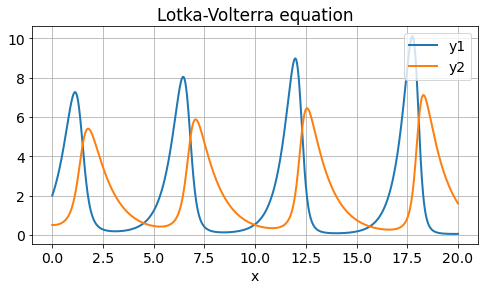

In [32]:
# Numerical example 2, system of equations.

# The right hand side of the ODE
# NB! y is an array of dimension 2, and so is dy. 
def lotka_volterra(x, y):
    alpha, beta, delta, gamma = 2, 1, 0.5, 1     # Set the parameters
    dy = np.array([alpha*y[0]-beta*y[0]*y[1],        
                   delta*y[0]*y[1]-gamma*y[1]])
    return dy

x0, xend = 0, 20            # Integration interval
y0 = np.array([2, 0.5])        # Initital values

# Solve the equation
x_lv, y_lv = ode_solver(lotka_volterra, x0, xend, y0, h=0.02) 

# Plot the solution
plt.plot(x_lv,y_lv);
plt.xlabel('x')
plt.title('Lotka-Volterra equation')
plt.legend(['y1','y2'],loc=1);

# Theory

## Existence and uniqueness results
Let us first state the conditions for which the ODE has a unique solution. 
We will need the following definition (which will also be used later in this note):

**Definition: Lipschitz condition.**

A function $f:\mathbb{R}\times\mathbb{R}^{m}\rightarrow\mathbb{R}^{m}$
satisfies the *Lipschitz condition* with respect to $y$ on a
domain $(a,b)\times D$ where $D\subset\mathbb{R}^{m}$ if there exist
a constant $L$ so that

$$
\|\mb{f}(x,\mb{y})-\mb{f}(x,\mb{z})\|\leq L \|\mb{y}-\mb{z}\|,\qquad\text{for all }\quad x\in(a,b),\; \mb{y},\mb{z}\in D.
$$

The constant $L$ is called *the Lipschitz constant*.



It is not hard to show that the function $\mb{f}$ satisfies the Lipschitz
condition if $\partial f_{i}/\partial y_{j},\; i,j=1,\cdots,m$ are
continuous and bounded on the domain and $D$ is open and convex.  


**Theorem: Existence and uniqueness of a solution.**

Consider the initial value problem

$$
\mb{y}'=\mb{f}(x,\mb{y}),\qquad \mb{y}(x_{0})=\mb{y}_{0}.
$$

If
* $\mb{f}(x,\mb{y})$ is continuous in $(a,b)\times D$,

* $\mb{f}(x,\mb{y})$ satisfies the Lipschitz condition with respect to $\mb{y}$ in  $(a,b)\times D$. 

with given initial values $x_{0}\in(a,b)$ and $y_{0}\in D$, then
the ODE has one and only one solution in $(a,b)\times D$.



## Error analysis

When an ODE is solved by Euler's method over some interval $[x_0,x_{end}]$, how
will the error at $x_{end}$ (or some arbitrary point) depend on the number of
steps. Or more spesific, choose the number of steps $N$, let the step size be
$h=(x_{end}-x_0)/N$, such that $x_{end}=x_N$, what can we say about the error $e_N = y(x_{end})-y_N$? 

**Numerical example 4:**
Solve the equation of Example 1,

$$
y'(x) = -2xy(x), \qquad y(0)=1,
$$

with exact solution $y(x) =  e^{-x^2}$, 
over the interval $[0,1]$.  Use different
step sizes $h$, and for each $h$, measure the error at $x=1$.

In [33]:
# Numerical example 4
def f(x, y):                # The right hand side of the ODE
    return -2*x*y

def y_exact(x):            # The exact solution
    return np.exp(-x**2)

h = 0.1                     # The stepsize
x0, xend = 0, 1             # Integration interval
y0 = 1                      # Initial value

print('h           error\n---------------------')

# Main loop
for n in range(10):
    x_num, y_num = ode_solver(f, x0, xend, y0, h)   # Solve the equation 
    error = abs(y_exact(xend)-y_num[-1])            # Error at the end point
    print(f'{h:.3e}   {error:.3e}')   
    h = 0.5*h                                       # Reduce the stepsize

h           error
---------------------
1.000e-01   1.383e-02
5.000e-02   6.505e-03
2.500e-02   3.157e-03
1.250e-02   1.555e-03
6.250e-03   7.720e-04
3.125e-03   3.846e-04
1.563e-03   1.920e-04
7.813e-04   9.589e-05
3.906e-04   4.792e-05
1.953e-04   2.396e-05


The table generated from this code shows that whenever the step size is reduced
with a factor of 0.5, so is the error. Therefore, we expect

$$
|y(x_{end}) - y_N| \approx C h, \qquad h=\frac{x_{end}-x_0}{N}.
$$

The method seems to be of order 1, see *Preliminaries*, section 3.1.

In the following we will prove that this is in fact the case. The error analysis will be done on a scalar equation, but it can as well be extended to systems of equations, as described in the end of the section. 

### Local and global errors

In this discussion we have to consider two kinds of errors: 

* *Local truncation error* $d_{n+1}$: This is the error done on one step, starting from $(x_n,y(x_n))$. 

* *Global error* $e_{n}$: This is the difference between the exact and the numerical solution after $n$ steps, that is $e_{n} = y(x_n)-y_n$.

In the following, we will see how to express the local truncation error, and we will see how the global and the local errors are related. We will use all this to find an upper bound for the global error at the end point $x_N=x_{end}$. The technique described here is quite standard for this type of error analysis.

Let us start with the local truncation error. Euler's method is nothing but the first two terms of the Taylor expansion of the exact solution. As a consequence, the local truncation error is the remainder term $R_{2}(x)$ (see *Preliminaries*, section 4):

$$
d_{n+1} = y(x_n+h) - \big( y(x_n) + h y'(x_n) \big) = \frac{1}{2}h^2 y''(\xi), \qquad \xi \in (x_n, x_n+h).
$$

Next, we use the fact that  $y'(x_n) = f(x_n, y(x_n))$ and obtain the following two expressions:

$$
\begin{align*}
 y(x_n+h) &= y(x_n) + h f(x_n,y(x_n)) + d_{n+1},  & \text{the equation above} \\ 
 y_{n+1} &= y_n + h f(x_n, y_n), & \text{Euler's method}
\end{align*}
$$

We subtract the second from the first, use that $e_{n} = y(x_n)-y_n$, and finally use Result 3 in *Preliminaries*, section 5.
This yields the expression

$$
e_{n+1} = e_n + h \big( f(x_n, y(x_n)) - f(x_n, y_n) \big) + d_{n+1}
          = e_n + h f_y(x_n, \eta) e_n + d_{n+1},
$$

where  $f_y = \frac{\partial f}{\partial y}$, and $\eta$ is some value between $y_n$ and $y(x_n)$. 
We now take the absolute value on each side, and apply the triangle inequality:

$$
|e_{n+1}| = |e_n + h f_y(x_n, \eta) e_n + d_{n+1}| \le  |e_n| + h |f_y(x_n, \eta)|| e_n| + |d_{n+1}|.
$$

Assume now that there exist positive constants $D$ and $L$ satisfying

$$
|f_y(x,y)| \leq L \qquad \text{and} \qquad |y''(x)| \leq 2D
$$

for all values of $x$, $y$. From the inequality above we get that

$$
|e_{n+1}| \le (1+hL)|e_n| + Dh^2.
$$

Since $y_0=y(x_0)$ we get $e_0=0$. The inequality above therefore results in
the following estimates for the global errors:

$$
\begin{align*}
|e_1| &\leq Dh^2 \\ 
|e_2| & \leq (1+hL)|e_1| + Dh^2 \leq \big((1+hL)+1\big) Dh^2 \\ 
|e_3| &\leq (1+hL)|e_2|+ Dh^2 \leq \big((1+hL)^2 + (1+hL) + 1\big) Dh^2 \\ 
& \vdots \\ 
|e_N| & \leq (1+hL)|e_{N+1}|+ Dh^2 \leq \sum_{n=0}^{N-1} (1+hL)^n Dh^2
\end{align*}
$$

We will now apply two well known results: 
* The sum of a truncated geometric series: 

  * $\displaystyle \sum_{n=0}^{N-1}r^n = \frac{r^N-1}{r-1}$ for $r\in \mathbb{R}$. 


* The series of the exponential: 

  * $\displaystyle e^x = 1+x+ \frac{1}{2}x^2 + \dotsm = 1+x+ \sum_{n=2}^{\infty}\frac{x^n}{n!}$ 

  which proves that $1+x < e^x$ whenever $x>0$. 

Using these results, we obtain that

$$
\sum_{n=0}^{N-1} (1+hL)^n = \frac{(1+hL)^N-1}{(1+hL)-1}
< \frac{(e^{hL})^N-1}{hL} = \frac{e^{hLN}-1}{hL}
= \frac{e^{L(x_{end}-x_0)}-1}{hL},
$$

where the last equality holds because $(x_{end}-x_0)=hN$. 
Finally, we plug this into the inequality for $|e_{N}|$ above,
and we see that we have proved the the following upper bound for the global:

$$
|y(x_{end}) - y_N| = |e_N| \leq \frac{e^{L(x_{end}-x_0)}-1}{L} D h =  C h,
$$

where the constant $C=\frac{e^{L(x_{end}-x_0)}-1}{L} D$ depends on the length of the integration interval $x_{end}-x_0$, of certain properties of the equation ($L$ and $D$), but *not* on the step size $h$.

The numerical solution converges to the exact solution since

$$
\lim_{N\rightarrow \infty} |e_N| = 0.
$$

If the step size is reduced by a factor of 0.5, so will the error.
This is in agreement with the previous numerical result. 

**Remark:**
Following the proof of the error estimate for Euler's method,
we see that a local truncation error of size $h^2$ leads
to a final, global error of size $h$.
Intuitively, this is because we need to take roughly $1/h$ steps
in order to reach the point $x_{end}$,
although a precise proof is quite a bit more complicated than that, as we have seen.
However, what this also should mean is that a method
with a truncation order of size $h^{p+1}$ should lead to a global error of $h^p$.
The results of the next section show that, under certain
conditions, this is indeed the case.


## A general convergence result

A one-step method applied to a system of ODEs $\mb{y}'(x)=\mb{f}(x,\mb{y}(x))$ can be written in the generic form

$$
\mb{y}_{n+1} = \mb{y}_n + h \mb{\Phi}(x_n, \mb{y}_n; h),
$$

where the *increment function* $\mb{\Phi}$ typically depends on the function $\mb{f}$ and some parameters defining the method.

**Definition: Order of a method.**

A method is of order $p > 0$ if there is a constant $C > 0$
such that

$$
\|\mb{e}_N\| = \|\mb{y}(x_{end})-\mb{y}_N\| \leq C h^p,
$$

where $N$ is the number of steps taken to reach $x_{end}$ using the step size $h=(x_{end}-x_0)/N$.



The local truncation error $\mb{d}_{n+1}$ of such a method is

$$
\mb{d}_{n+1} = \mb{y}(x_{n+1}) - \left (\mb{y}(x_n) + h \mb{\Phi}(x_n, \mb{y}(x_n); h)\right)
$$

Replace the absolute values in the above proof with norms (*Preliminaries*, section 1), and the
argument above can be used to prove the following: 



**Theorem: Convergence of one-step methods.**

Assume that there exist  positive constants $M$ and $D$ such that the increment function satisfies

$$
\| \mb{\Phi}(x,\mb{y};h) - \mb{\Phi}(x,\mb{z};h) \| \leq M \| \mb{y}-\mb{z} \|
$$

and the local truncation error satisfies

$$
\| \mb{y}(x+h) - \left (\mb{y}(x) + h \mb{\Phi}(x, \mb{y}(x), h)\right) \| \leq Dh^{p+1}
$$

for all $x$, $\mb{y}$ and $\mb{z}$ in a neighbourhood of the solution. In that case, the global error satisfies

$$
\|\mb{e}_N\| = \|\mb{y}(x_{end})-\mb{y}_N\| \leq C h^p, \qquad\text{ with } C =
\frac{e^{M(x_{end}-x_0)}-1}{M}D.
$$

**Example:**
Let us consider Eulers method, $\mb{y}_{n+2} = \mb{y}_n + h\mb{f}(x_n,\mb{y}_n)$. So in this case 
$\mb{\Phi}(x,\mb{y}) = \mb{f}(x_n,\mb{y}_n)$ and the first condition is satisfied as long as $\mb{f}$ satisfy the Lipschitz condition in $\mb{y}$.


It can be proved that the first of these conditions is satisfied for all the methods that will be considered here,
provided that the function $\mb{f}$ is continuously differentiable.


### Heun's method

We will now discuss a first, improved alternative to Euler's method:

Assume that we want to solve an

$$
\mb{y}'(x) = \mb{f}(x,\mb{y}(x)).
$$

Its exact solution can be written in integral form as

$$
\mb{y}(x_n + h) =
\mb{y}(x_n) + \int_{x_n}^{n_n + h} \mb{y}'(x)\,dx
=
\mb{y}(x_n) + \int_{x_n}^{x_{n}+h} \mb{f}(x,\mb{y}(x)) dx.
$$

We now replace the integral on the right hand side
by a numerical approximation using the trapezoidal rule:

$$
\mb{y}(x_n+h) \approx \mb{y}(x_n) + \frac{h}{2}
\big(\mb{f}(x_n, \mb{y}(x_n)) + \mb{f}(x_{n+1},\mb{y}(x_{n+1})\big).
$$

Then we replace $\mb{y}(x_n)$ and $\mb{y}(x_{n+1})$ by the approximations
$\mb{y}_n$ and $\mb{y}_{n+1}$. The resulting method is the *trapezoidal rule for ODEs*, given by

$$
\mb{y}_{n+1} = \mb{y}_{n} + \frac{h}{2} \big( \mb{f}(x_n,\mb{y}_n) + \mb{f}(x_{n+1},\mb{y}_{n+1})\big).
$$

This is an example of an *implicit* method.
The numerical approximation $\mb{y}_{n+1}$ appears on both
sides of this equation as is therefore only implicitly given:
If $x_n,\mb{y}_n$ is known, a nonlinear equation has to be solved
in order to find $\mb{y}_{n+1}$, and this has to be done for each step.
There are important applications where this actually makes sense,
which we will discuss in a later lecture in the context of *stiff ODEs*.

However, for the moment we want to avoid this additional complication
and thus replace the $\mb{y}_{n+1}$ on the right hand side by some
approximation. One natural possibility here is to apply one step
of Euler's method.
This results in [Heun's method](https://wiki.math.ntnu.no/tma4100/tema/differentialequations?&#numeriske_losninger):

$$
\begin{align*}
   \mb{u}_{n+1} &= \mb{y}_n + h \mb{f}(x_n, \mb{y}_n), \\ 
   \mb{y}_{n+1} &= \mb{y}_n + \frac{h}{2} \big(\mb{f}(x_n,\mb{y}_n) + \mb{f}(x_{n+1},\mb{u}_{n+1}) \big).
\end{align*}
$$

The method is commonly written in the form

$$
\begin{align*}
  \mb{k}_1 &= \mb{f}(x_n, \mb{y}_n), \\ 
  \mb{k}_2 &= \mb{f}(x_n+h, \mb{y}_n+h \mb{k}_1), \\ 
  \mb{y}_{n+1} &= \mb{y}_n + \frac{h}{2}(\mb{k}_1 + \mb{k}_2).
\end{align*}
$$

The increment function for this method is

$$
\mb{\Phi}(x,\mb{y};h) = \frac{1}{2}\big(\mb{f}(x,\mb{y})+\mb{f}(x+h,\mb{y}+h\mb{f}(x,\mb{y}))\big).
$$

### Implementation

One step of Heuns's method is implemented as follows:

In [34]:
def heun(f, x, y, h):
    # One step of Heun's method
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_next = y + 0.5*h*(k1+k2)
    x_next = x + h
    return x_next, y_next

**Numerical example 5:**
Let us compare the numerical solution from Euler's and Heun's methods on the scalar test 
problem

$$
y' = -2xy, \qquad y(0)=1
$$

with the exact solution
$y(x) = e^{-x^2}$ on the interval $[0,1]$.
Use  $h=0.1$ for Euler's method and $h=0.2$ for Heun's metode. Thus both require a total of 10
function evaluations, and the total amount of computational work is comparable.

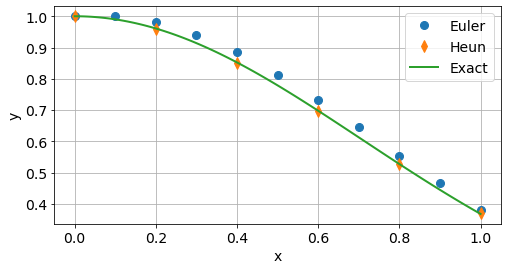

In [35]:
# Numerical experiment 5

def f(x, y):            # The right hand side of the ODE
    return -2*x*y

def y_exact(x):         # The exact solution
    return np.exp(-x**2)

h = 0.1                 # The stepsize
x0, xend = 0, 1         # Integration interval             
y0 = 1                  # Initial value

# Solve the equations
xn_euler, yn_euler = ode_solver(f, x0, xend, y0, h, method=euler)
xn_heun, yn_heun = ode_solver(f, x0, xend, y0, 2*h, method=heun)     

# Plot the solution
x = np.linspace(x0, xend, 101)
plt.plot(xn_euler, yn_euler, 'o') 
plt.plot(xn_heun, yn_heun, 'd')
plt.plot(x, y_exact(x))
plt.legend(['Euler','Heun','Exact']);
plt.xlabel('x')
plt.ylabel('y');

The errors of the two approximations are:

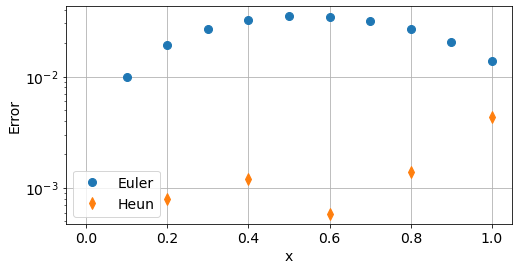

In [36]:
# Plot the error of the two methods
plt.semilogy(xn_euler, abs(y_exact(xn_euler)- yn_euler), 'o');
plt.semilogy(xn_heun, abs(y_exact(xn_heun)- yn_heun), 'd');
plt.xlabel('x')
plt.ylabel('Error')
plt.legend(['Euler', 'Heun'],loc=3)

Let us finally compare the error  at $x_{end}$ when the two methods are applied to our test problem,
 for different values of $h$:

In [37]:
# Print the error as a function of h. 
print('Error in Euler and Heun\n')
print('h           Euler       Heun')
print('---------------------------------')
for n in range(10):
    x_euler, y_euler = ode_solver(f, x0, xend, y0, h, method=euler)
    x_heun, y_heun = ode_solver(f, x0, xend, y0, 2*h, method=heun)
    error_euler = abs(y_exact(xend)-y_euler[-1])
    error_heun = abs(y_exact(xend)-y_heun[-1])
    print(f'{h:.3e}   {error_euler:.3e}   {error_heun:.3e}')
    h = 0.5*h

Error in Euler and Heun

h           Euler       Heun
---------------------------------
1.000e-01   1.383e-02   4.308e-03
5.000e-02   6.505e-03   1.174e-03
2.500e-02   3.157e-03   3.011e-04
1.250e-02   1.555e-03   7.601e-05
6.250e-03   7.720e-04   1.909e-05
3.125e-03   3.846e-04   4.781e-06
1.563e-03   1.920e-04   1.196e-06
7.813e-04   9.589e-05   2.992e-07
3.906e-04   4.792e-05   7.483e-08
1.953e-04   2.396e-05   1.871e-08


First of all, Heun's method is significantly more accurate than Euler's method, even when the 
number of function evaluations are the same. Further, we notice that the error in Heun's method is reduced by a factor of approximately 1/4 whenever the step size is reduced by a factor 1/2, indicating that the error $|y(x_{end}-y_N| \approx Ch^2$, and the method is of order 2.  

**Numerical example 6:**
Solve the Lotka-Volterra equation from Numerical example 2 by Euler's and Heun's methods, again using twice as many steps for Euler's method than for Heun's method. 
* Use $h=0.01$ for Euler's method and $h=0.02$ for Heun's method. 

* Use $h=0.1$ for Euler's method and $h=0.2$ for Heun's method.

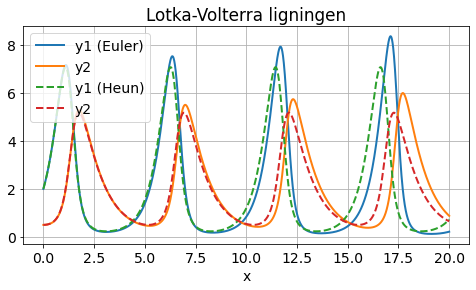

In [38]:
# Numerical example 6

def lotka_volterra(x, y):       # The Lotka-Volterra equation
    alpha, beta, delta, gamma = 2, 1, 0.5, 1        # Parameters
    dy = np.array([alpha*y[0]-beta*y[0]*y[1],  
                delta*y[0]*y[1]-gamma*y[1]])
    return dy

x0, xend = 0, 20
y0 = np.array([2, 0.5])
h = 0.01

x_euler, y_euler = ode_solver(lotka_volterra, x0, xend, y0, h, method=euler)
x_heun, y_heun = ode_solver(lotka_volterra, x0, xend, y0, 2*h, method=heun)

plt.plot(x_euler,y_euler)
plt.plot(x_heun, y_heun, '--')
plt.xlabel('x')
plt.title('Lotka-Volterra ligningen')
plt.legend(['y1 (Euler)','y2', 'y1 (Heun)', 'y2'],loc=2)

**Numerical exercises:**
1. Solve Van der Pol's equation by use of Heun's method and with Euler's method, and compare.  Experiment with different choices of the step size $h$. Use $\mu=2$, and solve the equation on the interval [0,20]. Experiment with different values of $\mu$.

2. Implement the [classical Runge - Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods#The_Runge–Kutta_method) and verify numerically that the order of the method is 4. The method is given by

$$
\begin{align*}
   \mb{k}_1 &= \mb{f}(x_n, \mb{y}_n)\\ 
   \mb{k}_2 &= \mb{f}\left(x_n+\frac{h}{2}, \mb{y}_n + \frac{h}{2}\mb{k}_1\right) \\ 
   \mb{k}_3 &= \mb{f}\left(x_n+\frac{h}{2}, \mb{y}_n + \frac{h}{2}\mb{k}_2\right) \\ 
   \mb{k}_4 &= \mb{f}(x_n+h, \mb{y}_n + h\mb{k}_3)\\ 
   \mb{y}_{n+1} &= \mb{y}_n + \frac{h}{6}(\mb{k}_1 + 2\mb{k}_2 + 2\mb{k}_3 + \mb{k}_4).
   \end{align*}
$$

### Convergence properties of Heun's method

To prove convergence and to find the order of a method two things are needed: 
* the local truncation error, expressed as a power series in the step size $h$

* the condition  $\| \mb{\Phi}(x,\mb{y};h) - \mb{\Phi}(x,\mb{z};h) \| \leq M \| \mb{y}-\mb{z} \|$

The local truncation error is found by comparing Taylor series expansions of the exact and the numerical solutions starting from the same point. In practice, this is not trivial. For simplicity, we will here do this only for a scalar equation $y'(x)=f(x,y(x))$. The result is valid for systems as well.

In the following, we will use the notation

$$
f_x = \frac{\partial f}{\partial x}, \qquad f_y = \frac{\partial f}{\partial y}, 
\qquad f_{xx} = \frac{\partial^2 f}{\partial x^2} \qquad  f_{xy} 
= \frac{\partial^2f}{\partial x\partial y} \qquad\text{etc.}
$$

Further, we will surpress the arguments of the function $f$ and its derivatives. So $f$ is to be understood as $f(x,y(x))$ although it is not explicitly written. 


The Taylor expansion of the exact solution $y(x+h)$ is given by

$$
y(x+h)=y(x)+hy'(x) + \frac{h^2}{2}y''(x) + \frac{h^3}{6}y'''(x) + \ldots.
$$

Higher derivatives of $y(x)$ can be expressed in terms of the function $f$ by using the chain rule and the product rule for differentiation:

$$
\begin{align*}
    y'(x) &= f, \\ 
    y''(x) &= f_x  + f_y y' = f_x + f_y f,\\ 
    y'''(x) &= f_{xx} + f_{xy} y' + f_{yx}f + f_{yy}y'f + f_yf_x +f_y f_y y' 
             = f_{xx}+2f_{xy}f+f_{yy}f^2 +f_yf_x+ (f_y)^2f.
\end{align*}
$$

We then find the series of the exact and the numerical solution around $x_0,y_0$ (any other point will do equally well). From the discussion above, the series for the exact solution becomes

$$
y(x_0+h) = y_0 + hf + \frac{h^2}{2}(f_x + f_y f) +
\frac{h^3}{6}(f_{xx}+2f_{xy}f+f_{yy}f^2 + f_yf_x+ (f_y)^2f
) + \ldots,
$$

where $f$ and all its derivatives are evaluated in $(x_0,y_0)$. For the numerical solution we get

$$
\begin{align*}
  k_1 &= f(x_0,y_0) = f, \\ 
  k_2 &= f(x_0+h, y_0+hk_1) \\ 
      & = f + hf_x + f_yhk_1 + \frac{1}{2}f_{xx}h^2 + f_{xy}hhk_1 + \frac{1}{2}f_{yy}h^2 k_1^2 
       + \ldots \\ 
      &= f + h(f_x + f_yf) + \frac{h^2}{2}(f_{xx} + 2f_{xy}f + f_{yy}f^2) + \ldots, \\ 
  y_1 &= y_0 + \frac{h}{2}(k_1 + k_2) = y_0 + \frac{h}{2}\Bigl(f + f + h(f_x + f_yf) + \frac{h^2}{2}(f_{xx} + 2f_{xy}f + f_{yy}f^2) + \ldots\Bigr) \\ 
      &= y_0 + hf + \frac{h^2}{2}(f_x+f_yf)+ \frac{h^3}{4}(f_{xx} + 2f_{xy}f + f_{yy}f^2)  + \ldots,
\end{align*}
$$

and the local truncation error will be

$$
d_{1} = y(x_0+h)-y_1 = \frac{h^3}{12}(-f_{xx}-2f_{xy}f-f_{yy}f^2 + 2f_yf_x + 2(f_y)^2f) + \ldots.
$$

The first nonzero term in the local truncation error series is called *the principal error term*. For $h$ sufficiently small this is the term dominating the error, and this fact will be used later. 

Although the series has been developed around the initial point, series around $x_n,y(x_n)$ will give 
similar results, and it is possible to conclude that, given sufficient differentiability of $f$, there is a constant $D$ such that

$$
|d_n| \leq Dh^3.
$$

Further, we have to prove the condition on the increment function $\Phi(x,y)$. For $f$ differentiable, there is for all $y,z$ some $\xi$ between $x$ and $y$ such that $f(x,y)-f(x,z) = f_y(x,\xi)(y-z)$. Let $L$ be a constant such that $|f_y| \le L$, and for all $x$, $y$, $z$ of interest we get

$$
|f(x,y)-f(x,z)| \leq L |y-z|.
$$

The increment function for Heun's method is given by

$$
\Phi(x,y) = \frac{1}{2}\bigl(f(x,y)+f(x+h,y+hf(x,y))\bigr). \\
$$

By repeated use of the condition above and the triangle inequalitiy for absolute values we get

$$
\begin{align*}
|\Phi(x,y)-\Phi(x,z)| &= \frac{1}{2}|f(x,y)+f(x+h,y+hf(x,y))-f(x,z)-hf(x+h,z+hf(x,z))| \\ 
&\leq \frac{1}{2}\big(|f(x,y)-f(x,z)|+|f(x+h,y+hf(x,y))-f(x+h,z+hf(x,z))| \big) \\ 
&\leq \frac{1}{2}\big(L|y-z| + L|y+hf(x,y)-z-hf(x,z)| \big) \\ 
&\leq \frac{1}{2}\big(2L|y-z|+hL^2|y-z|\big) \\ 
& = \Bigl(L+\frac{h}{2}L^2\Bigr)|y-z|.
\end{align*}
$$

Assuming that the step size $h$ is bounded above by some $H$, we can conclude that

$$
|\Phi(x,y)-\Phi(x,z)| \leq M|y-z|, \qquad M=L+\frac{H}{2}L^2.
$$

In conclusion: Heun's method is convergent of order 2.  

# Error estimation and step size control

To control the global error $y(x_n)-y_n$ is notoriously difficult, and far beyond what will 
be discussed in this course. To control the local error in each step and adjust the step size 
accordingly is rather straightforward, as we will see. 

## Error estimation
Given two methods, one of order $p$ and the other of order $p+1$ or higher. Assume we have 
reached a point $(x_n,\mb{y}_n)$. One step forward with each of these methods can be written as

$$
\begin{align*} 
  \mb{y}_{n+1} &= \mb{y}_n + h \mb{\Phi}(x_n, \mb{y}_n; h), && \text{order $p$}, \\ 
  \widehat{\mb{y}}_{n+1} &= \mb{y}_n + h \widehat{\mb{\Phi}}(x_n, \mb{y}_n; h), && \text{order $p+1$ or more}. \\ 
\end{align*}
$$

Let $\mb{y}(x_{n+1};x_n,\mb{y}_n)$ be the exact solution of the ODE through $(x_n,\mb{y}_n)$. 
We would like to find an estimate for *the local error* $\mb{l}_{n+1}$, that is, the error in one step starting from  $(x_n, \mb{y}_n)$,

$$
\mb{l}_{n+1} = \mb{y}(x_{n+1};x_n,\mb{y}_n) - \mb{y}_{n+1}.
$$

As we already have seen, the local error is found by finding the power series in $h$ of the exact 
and the numerical solution. The local error is of order $p$ if the lowest order terms in the series where the exact and the numerical solution differ is of order $p+1$. So the local errors of the two methods are

$$
\begin{align*}
\mb{y}(x_{n+1};x_n,\mb{y}_n) - \mb{y}_{n+1} &= \mb{\Psi}(x_n,y_n)h^{p+1}  +\dotsc, \\ 
\mb{y}(x_{n+1};x_n,\mb{y}_n) - \widehat{\mb{y}}_{n+1} &= \hphantom{\mb{\Psi}(x_n,y_n)h^{p+1} } + \dotsc,
\end{align*}
$$

where $\Psi(x_n,y_n)$ is a term consisting of method parameters and differentials of $\mb{f}$ and 
$\dotsc$ contains all the terms of the series of order $p+2$ or higher. Taking the difference gives

$$
\widehat{\mb{y}}_{n+1} - \mb{y}_{n+1} = \mb{\Psi}(x_n,\mb{y}_n)h^{p+1} + \ldots.
$$

Assume now that $h$ is small, such that the *principal error term* $\mb{\Psi(x_n,y_n)}h^{p+1}$ dominates the error series. Then a reasonable approximation to the unknown local error $\mb{l}_{n+1}$ is the *local error estimate* $\mb{le}_{n+1}$:

$$
\mb{le}_{n+1} = \widehat{\mb{y}}_{n+1} - \mb{y}_{n+1} \approx \mb{y}(x_{n+1};x_n,\mb{y}_n) - \mb{y}_{n+1}.
$$

**Example 4:**
Apply Euler's method of order 1 and Heun's method of order 2 with $h=0.1$ to the equation

$$
y' = -2xy, \qquad y(0)=1.
$$

Use this to find an approximation to the error after one step. 

Euler's method:

$$
y_1 = 1.0 - 0.1\cdot 2 \cdot 0 \cdot 1.0 = 1.0.
$$

Heun's method

$$
\begin{align*}
 k_1 &= -2\cdot 0.0 \cdot 1.0 = 0.0,  \\ 
 k_2 &= -2\cdot 0.1\cdot (1+0.0) = -0.2, \\ 
 \widehat{y}_1&  = 1.0 + \frac{0.1}{2}\cdot(0.0 - 0.2) = 0.99.
\end{align*}
$$

The error estimate and the local error are respectively

$$
le_{1} = \widehat{y}_1 - y_1 = -10^{-2}, \qquad
   l_1 = y(0.1)-y_1 = e^{-0.1^2}-1.0 =  -0.995 \cdot 10^{-2}.
$$

So in this case the error estimate is a quite decent approximation to the actual local error. 

## Stepsize control
The next step is to control the local error, that is, choose the step size so that $\|\mb{le}_{n+1}\| \leq \text{Tol}$ for some given tolerance Tol, and for some chosen norm $\|\cdot\|$. 

Essentially: 

Given $x_n, \mb{y}_n$ and a step size $h_n$. 
* Do one step with the method of choice, and find an error estimate $\mb{le}_{n+1}$. 

* if  $\|\mb{le}\|_{n+1} < \text{Tol}$

    * Accept the solution $x_{n+1}, \mb{y}_{n+1}$.

    * If possible, increase the step size for the next step.


* else

    * Repeat the step from $(x_n,\mb{y}_n)$ with a reduced step size $h_{n}$.


In both cases, the step size will change. But how? 

From the discussion above, we have that

$$
\| \mb{le}_{n+1} \| \approx D  h_{n}^{p+1}.
$$

where $\mb{le}_{n+1}$ is the error estimate we can compute, $D$ is some unknown quantity, which we assume almost constant from one step to the next. What we want is a step size $h_{new}$ such that

$$
\text{Tol} \approx D h_{new}^{p+1}.
$$

From these two approximations we get:

$$
\frac{\text{Tol}}{\|\mb{le}_{n+1}\|} \approx \left(\frac{h_{new}}{h_n}\right)^{p+1}
\qquad \Rightarrow \qquad
h_{new} \approx \left( \frac{\text{Tol}}{\|\mb{le}_{n+1}\|} \right)^{\frac{1}{p+1}} h_{n}.
$$

That is, if the current step $h_n$ was rejected, we try a new step $h_{new}$
with this approximation.
However, it is still possible that this new step will be rejected as well.
To avoid too many rejected steps, it is therefore common to be a bit restrictive when choosing the new 
step size, so the following is used in practice:

$$
h_{new} = P\cdot \left( \frac{\text{Tol}}{\|\mb{le}_{n+1}\|} \right)^{\frac{1}{p+1}} h_{n}.
$$

where the *pessimist factor* $P<1$ is some constant, normally chosen between 0.5 and 0.95.

## Implementation
We have all the bits and pieces for constructing an adaptive ODE solver based on Euler's and Heuns's methods. There are still some practical aspects to consider: 

* The combination of the two methods, implemented in `heun_euler` can be written as

$$
\begin{align*}
      \mb{k}_1 &= \mb{f}(x_n, \mb{y}_n), \\ 
      \mb{k}_2 &= \mb{f}(x_n+h, \mb{y}_n+h \mb{k}_1), \\ 
      \mb{y}_{n+1} &= \mb{y}_n + h \mb{k}_1, && \text{Euler} \\ 
      \widehat{\mb{y}}_{n+1} &= \mb{y}_n + \frac{h}{2}(\mb{k}_1 + \mb{k}_2), && \text{Heun} \\ 
      \mb{le}_{n+1} &= \|\widehat{\mb{y}}_{n+1} - \mb{y}_{n+1}\| = \frac{h}{2}\|\mb{k}_2-\mb{k}_1 \|.
    \end{align*}
$$

* Even if the error estimate is derived for the lower order method, in this case Euler's method, it is common to advance the solution with the higher order method, since the additional accuracy is for free. 

This is usually referred to as *local extrapolation*. 
* Adjust the last step to be able to terminate the solutions exactly in $x_{end}$. 

* To avoid infinite loops, add some stopping criteria. In the code below, there is a maximum number of allowed steps (rejected or accepted). 

* The main driver `ode_adaptive` is written to make it simple to test other pairs of methods. This is also the reason why the function `heun_euler` returns the order of the lowest order method.

In [39]:
def heun_euler(f, x, y, h):
    '''
    One step with the pair Heun/Euler
    Input: the function f, the present state xn and yn  and the stepsize h
    Output: the solution x and y in the next step, error estimate, and the
            order p of Eulers method (the lowest order)
    '''
    
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_next = y + 0.5*h*(k1+k2)      # Heuns metode (lokal ekstrapolasjon)
    x_next = x + h
    error_estimate = 0.5*h*norm(k2-k1)   # The 2-norm or the error estimate
    p = 1
    return x_next, y_next, error_estimate, p

In [45]:
def ode_adaptive(f, x0, xend, y0, h0, tol = 1.e-6, method=heun_euler):
    '''
    Adaptive solver for ODEs
        y' = f(x,y), y(x0)=y0
     
    Input: the function f, x0, xend, and the initial value y0
            intial stepsize h, the tolerance tol, 
             and a function (method) implementing one step of a pair.
    Ut: Array med x- og y- verdier. 
    '''

    y_num = np.array([y0])    # Array for the solutions y
    x_num = np.array([x0])    # Array for the x-values

    xn = x0                # Running values for  x, y and the stepsize h
    yn = y0 
    h = h0
    Maxcall = 100000        # Maximum allowed calls of method
    ncall = 0
    
    ###################################
    print(f'initial y_num: {y_num}')
    
    
    ############################
    
    
    # Main loop
    while xn < xend - 1.e-10:               # Buffer for truncation error
        # Adjust the stepsize for the last step
        if xn + h > xend:                   
            h = xend - xn 
        
        # Do one step with your chosen method
        x_try, y_try, error_estimate, p = method(f, xn, yn, h)
        ncall = ncall + 1
        
        if error_estimate <= tol:   
            # Solution accepted, update x and y
            xn = x_try    
            yn = y_try
            # Store the solutions 
            y_num = np.concatenate((y_num, np.array([yn])))
            x_num = np.append(x_num, xn)
        
        # else: The step rejectes and nothing is updated. 
        
        # Adjust the stepsize
        h = 0.8*(tol/error_estimate)**(1/(p+1))*h
        
        # Stop with a warning in the case of max calls to method
        if ncall > Maxcall:
            print('Maximum number of method calls')
            return x_num, y_num

    # Some diagnostic output
    print(f'Number of accepted steps = {len(x_num)-1:4d}')
    print(f'Number of rejected steps = {ncall-len(x_num)+1:4d}')
    return x_num, y_num

**Numerical example 7:**
Apply the code on the test equation:

$$
y' = -2xy, \qquad y(0)=1.
$$

Number of accepted steps =   27
Number of rejected steps =    2


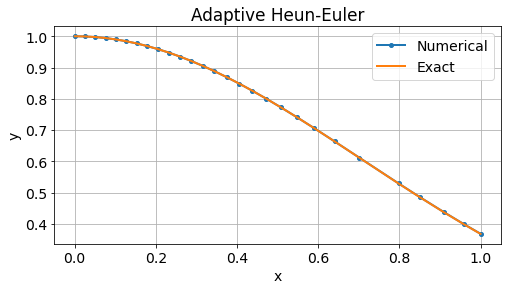

In [41]:
# Numerical example 7
def f(x, y):
    return -2*x*y

def y_exact(x):
    return np.exp(-x**2)

h0 = 100
x0, xend = 0, 1
y0 = 1

x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol=1.e-3)

plt.plot(x_num, y_num, '.-', x_num, y_exact(x_num))
plt.title('Adaptive Heun-Euler')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Numerical', 'Exact']);

The error $|y(x_n)-y_n|$ is:

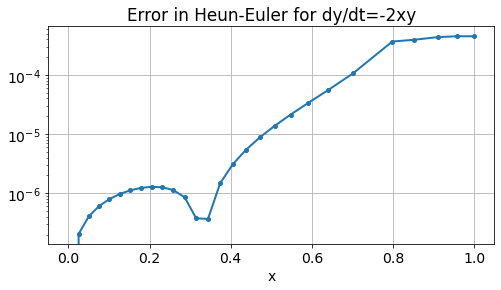

In [42]:
# Plot the error from the adaptive method
error = abs(y_exact(x_num) - y_num)
plt.semilogy(x_num, error, '.-')
plt.title('Error in Heun-Euler for dy/dt=-2xy')
plt.xlabel('x');

And the step size will change like

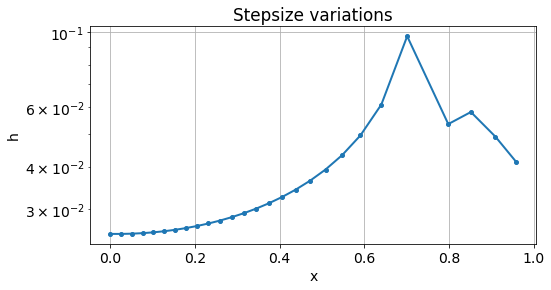

In [43]:
# Plot the step size sequence
h_n = np.diff(x_num)            # array with the stepsizes h_n = x_{n+1} 
x_n = x_num[0:-1]            # array with x_num[n], n=0..N-1
plt.semilogy(x_n, h_n, '.-')
plt.xlabel('x')
plt.ylabel('h')
plt.title('Stepsize variations');

**Numerical exercises:**
1. Solve the Lotka-Volterra equation, use for instance $h_0=0.1$ and $\text{Tol}=10^{-3}$. Notice also how the step size varies over the integration interval. 

2. Repeat the experiment using Van der Pol's equation. 

## Runge - Kutta methods
Euler's and Heun's method are both
examples of *explicit Runge-Kutta methods* (ERK). Such schemes
are given by

<!-- Equation labels as ordinary links -->
<div id="eq:erk"></div>

$$
\begin{align*}
  \label{eq:erk} \tag{1}
  \mb{k}_1 & = \mb{f}(x_n,\mb{y}_n), \\ 
  \mb{k}_2 & = \mb{f}(x_n+c_2h, \mb{y}_n+ha_{21}\mb{k}_1), \nonumber \\ 
  \mb{k}_3 & = \mb{f}\big(x_n+c_3h, \mb{y}_n+h(a_{31}\mb{k}_1 + a_{32}\mb{k}_2)\big), \nonumber \\ 
      & \vdots \nonumber \\ 
  \mb{k}_s &= \mb{f}\big(x_n+c_sh, \mb{y}_n + h\sum_{j=1}^{s-1}a_{sj}\mb{k}_j \big), \nonumber \\ 
  \mb{y}_{n+1} &= \mb{y}_n + h\sum_{i=1}^s b_i \mb{k}_i, \nonumber
\end{align*}
$$

where $c_i$, $a_{ij}$, and $b_i$ are coefficients defining the
method. We always require $c_i = \sum_{j=1}^s a_{ij}$. 
Here, $s$ is the number of *stages*, or the number of function
evaluations needed for each step. The vectors $\mb{k}_i$ are called stage
derivatives. Also implicit methods, like the trapezoidal rule,

$$
\mb{y}_{n+1} = \mb{y}_n+\frac{h}{2}\big(\mb{f}(x_n,\mb{y}_n)+\mb{f}(x_n+h,\mb{y}_{n+1})\big)
$$

can be written in a similar form,

$$
\begin{align*}
  \mb{k}_1 &= \mb{f}(x_n,\mb{y}_n), \\ 
  \mb{k}_2 &= \mb{f}\big(x_n+h,\mb{y}_n+\frac{h}{2}(\mb{k}_1+\mb{k}_2)\big), \\ 
  \mb{y}_{n+1} &= \mb{y}_n+\frac{h}{2}(\mb{k}_1+\mb{k}_2).
\end{align*}
$$

But, contrary to what is the case for explicit methods, a
nonlinear system of equations has to be solved to find $\mb{k}_2$.

**Definition: Runge - Kutta methods.**

An $s$-stage Runge-Kutta method is given by

$$
\begin{align*}
     \mb{k}_i &= \mb{f}\big(x_n+c_ih,\mb{y}_n+h\sum_{j=1}^s a_{ij}\mb{k}_j\big), \qquad i=1,2,\cdots,s, \\ 
     \mb{y}_{n+1} &= \mb{y}_n + h\sum_{i=1}^s b_i \mb{k}_i.
  \end{align*}
$$

The method is defined by its coefficients, which are given in a
*Butcher tableau*

$$
\begin{array}{c|cccc}
    c_1 & a_{11} & a_{12} & \cdots & a_{1s} \\ 
    c_2 & a_{21} & a_{22} & \cdots & a_{2s} \\ 
    \vdots & \vdots &&&\vdots \\ 
    c_s & a_{s1} & a_{s2} & \cdots & a_{ss} \\ \hline
        & b_1 & b_2 & \cdots & b_s 
  \end{array}
$$

with

$$
c_i = \sum_{j=1}^s a_{ij}, \quad
    i=1,\cdots,s.
$$

The method is *explicit* if $a_{ij}=0$ whenever $j\geq i$;
  otherwise it is *implicit*.



A Runge - Kutta methods with an error estimate are usually called *embedded Runge - Kutta methods* or *Runge - Kutta pairs*, and
the coefficients can be written in a Butcher tableau as follows

$$
\begin{array}{c|ccccl}
    c_1 & a_{11} & a_{12} & \cdots & a_{1s} \\ 
    c_2 & a_{21} & a_{22} & \cdots & a_{2s} \\ 
    \vdots & \vdots &&&\vdots \\ 
    c_s & a_{s1} & a_{s2} & \cdots & a_{ss} \\ \hline
        & b_1 & b_2 & \cdots & b_s  & \qquad\text{Order $p$}\\ \hline
        & \widehat{b}_1 & \widehat{b_2} & \cdots & \widehat{b}_s  & \qquad\text{Order $p+1$}
   \end{array}.
$$

The error estimate is then given by

$$
\mb{le}_{n+1} = h\sum_{i=1}^s (\widehat{b}_i - b_i)\mb{k}_i.
$$

**Example 5:**
  The Butcher-tableaux for the methods presented so far are

$$
\begin{array}{ccccccc}
    \displaystyle
    \begin{array}{c|c}
      0 & 0 \\ \hline & 1
    \end{array}
    & \qquad  &
    \displaystyle
    \begin{array}{c|cc}
      0 & 0 & 0\\ 1 & 1 &0 \\ \hline & \frac{1}{2} & \frac{1}{2} 
    \end{array}
    & \qquad &
    \displaystyle
    \begin{array}{c|cc}
      0 & 0 & 0 \\ 1 &  \frac{1}{2} & \frac{1}{2} \\ \hline & \frac{1}{2} & \frac{1}{2}  
    \end{array} \\ 
    \text{Euler} && \text{Heun} && \text{trapezoidal rule}
  \end{array}
$$

and the Heun-Euler pair can be written as

$$
\begin{array}{c|cc} 0 & & \\ 1 & 1 &   \\ \hline & 1 & 0 \\ \hline \displaystyle & \frac{1}{2} &  \frac{1}{2} 
 \end{array}
$$

A particular mention deserves also the classical Runge-Kutta method
from a previous numerical exercise, which can be written as

$$
\begin{array}{c|cccc}
      0 & 0 & 0 & 0 & 0\\ \frac{1}{2} &  \frac{1}{2} & 0 & 0 & 0\\ \frac{1}{2} & 0 & \frac{1}{2} & 0 & 0\\ 1 &  0 & 0 & 1 & 0 \\ \hline & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}  
    \end{array}
$$

See this [list of Runge - Kutta methods](https://en.wikipedia.org/wiki/List_of_Runge–Kutta_methods) for more. 

### Order conditions for Runge - Kutta methods

It can be proved that a Runge - Kutta method is of order $p$ if all the conditions up to and including $p$ in the table below are satisfied.

$$
\begin{array}{c|c|c} 
   p  & \text{conditions}  \\ \hline 
   1 & \sum b_i = 1 \\ \hline 
  2 & \sum b_i c_i = 1/2 \\ \hline 
  3 & \sum b_i c_i^2 = 1/3\\ 
   & \sum b_i a_{ij} c_j = 1/6 
  \\ \hline 
  4 & \sum b_ic_i^3=1/4 \\ 
  & \sum b_i c_i a_{ij}c_j=1/8 \\ 
  & \sum b_i a_{ij}c_j^2=1/12 \\ 
  & \sum b_i a_{ij} a_{jk} c_k = 1/24 \\ \hline 
\end{array}
$$

where sums are taken over all the indices from 1 to $s$. 

**Example 6:**
Apply the conditions to Heun's method, for which $s=2$ and the Butcher tableau is

$$
\begin{array}{c|cc} 
c_1 & a_{11} & a_{12} \\ c_2 & a_{21} & a_{22} \\ \hline & b_1 & b_2 
\end{array}
=
\begin{array}{c|cc}
0 & 0 & 0 \\ 1 & 1 & 0 \\ \hline & \frac{1}{2} & \frac{1}{2} 
\end{array}.
$$

The order conditions are:

$$
\begin{align*}
p&=1 & b_1 + b_2 &= \frac{1}{2} + \frac{1}{2}= 1 && \text{OK} \\ \mbox{}\\ \hline \\ 
p&=2 & b_1c_1 + b_2 c_2 &= \frac{1}{2}\cdot 0 + \frac{1}{2}\cdot 1 = \frac{1}{2} && \text{OK}\\ \mbox{} \\ \hline \\ 
p&=3 & b_1c_1^2 + b_2c_2^2 &= \frac{1}{2}\cdot 0^2 + \frac{1}{2}\cdot 1^2 = \frac{1}{2} \not= \frac{1}{3} && \text{Not satisfied} \\ 
 &   & b_1(a_{11}c_1+a_{12}c_2)+b_2(a_{21}c_1+a_{22}c_2) &= \frac{1}{2}(0\cdot0 + 0\cdot 1) + \frac{1}{2}(1\cdot 0 + 0\cdot 1) \\ 
      &&&= 0 \not=\frac{1}{6} && \text{Not satisfied}
\end{align*}
$$

The method is of order 2. 




# Stiff ODEs
When an ODE is solved by an adaptive solver we will expect that more steps are required for stricter tolerances. 
Specifically, the step size control is based on the assumption that the local error estimate $\mb{le}_{n+1}$ satisfies

$$
\|\mb{le}_{n+1}\| \approx Dh_n^{p+1} \approx \text{Tol},
$$

where $p$ is the order of the lowest order method, and $D$ is independent of the step size
$h$. The constant $D$ depends on the solution point $(x,\mb{y}_n)$, but it will usually
not change much from one step to the next. 

If we use different tolerances $\text{Tol}_1$ and $\text{Tol}_2$ for
the solution of the same problem with the same adaptive method,
we will therefore expect that the step sizes $h_1$ and $h_2$ near the same
point will behave like

$$
\text{Tol}_1 \approx D h_{1}^{p+1}, \qquad
  \text{Tol}_2 \approx D h_2^{p+1},
$$

so that

$$
\frac{h_1}{h_2} \approx \left( \frac{\text{Tol}_1}{\text{Tol}_2} \right)^{\frac{1}{p+1}} \approx \frac{N_2}{N_1}.
$$

where $N_1$ and $N_2$ are the total number of steps used for the two tolerances.

In the case of the Heun-Euler scheme, the lower order is
$p=1$. By reducing the tolerance by a factor
$1/100$ we will expect that the number of steps increases by a factor of 10. 


**Numerical example 1:**
Given the following system of two ODEs

$$
\begin{align*}
  y_1' &= -2y_1 + y_2 + 2\sin(x), & y_1(0) &= 2, \\ 
  y_2' &= (a-1) y_1 - a y_2 + a\,\big(\cos(x)-\sin(x) \big), & y_2(0) &= 3,
\end{align*}
$$

where $a$ is some positive parameter. The exact solution, which is independent of the
parameter, is

$$
y_1(x) = 2 e^{-x} + \sin(x), \qquad y_2(x) = 2e^{-x} + \cos(x).
$$

Solve this problem now with some adaptive ODE solver, for
instance the Heun-Euler scheme. 

Now try the tolerances $\text{Tol}=10^{-2}, \, 10^{-4}, \, 10^{-6}$,
and perform the experiment with
two different values of the parameters, $a=2$ and $a=999$.


Tol = 1.0e-02
initial y_num: [[2 3]]
Number of accepted steps =   93
Number of rejected steps =    2

Tol = 1.0e-04
initial y_num: [[2 3]]
Number of accepted steps =  869
Number of rejected steps =    1

Tol = 1.0e-06
initial y_num: [[2 3]]
Number of accepted steps = 8631
Number of rejected steps =    1


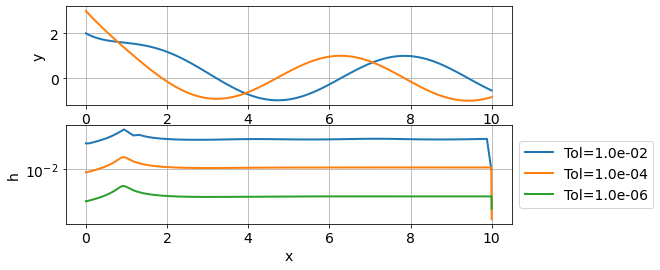

In [47]:
# Numerical example 1s
# Define the function
def f(x, y):
    a = 2
    dy = np.array([-2*y[0]+y[1]+2*np.sin(x),
                (a-1)*y[0]-a*y[1]+a*(np.cos(x)-np.sin(x))])
    return dy

# Initial values and integration interval 
y0 = np.array([2, 3])
x0, xend = 0, 10
h0 = 0.1

tol = 1.e-2
# Solve the ODE using different tolerances 
for n in range(3):
    print('\nTol = {:.1e}'.format(tol)) 
    x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol, method=heun_euler)
    
    if n==0:
        # Plot the solution
        plt.subplot(2,1,1)
        plt.plot(x_num, y_num)
        plt.ylabel('y')
        plt.subplot(2,1,2)

    # Plot the step size control
    plt.semilogy(x_num[0:-1], np.diff(x_num), label='Tol={:.1e}'.format(tol));
    
    tol = 1.e-2*tol         # Reduce the tolerance by a factor 0.01.
plt.xlabel('x')
plt.ylabel('h')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

For $a=2$ the expected behaviour is observed. But the example $a=999$ requires much more steps, and 
the step size seems almost independent of the tolerance, at least for $\text{Tol}=10^{-2}, \, 10^{-4}$. 


The example above with $a=999$ is a typically example of a *stiff ODE*.
What defines these types of ODEs is that there are (at least)
two different time scales at play at the same time: a slow time scale
that dominates the time evolution of the solution of the ODE,
and a fast time scale at which small perturbations of the solution may occur.
In physical systems, this might be due to very
strong damping of selected components of the system.

If we consider for instance the ODE in the numerical example above,
then we obtain, after some computation, that the general solution is

$$
\mb{y}(x) = c_1 \left(\begin{array}{c} 1 \\ 1 \end{array}\right) e^{-x}
             + c_2 \left(\begin{array}{c} -1 \\ a-1 \end{array}\right) e^{-(a+1)x}
             + \left(\begin{array}{c} \sin(x) \\ \cos(x) \end{array}\right)
$$

for some constants $c_1$, $c_2$.
The terms $e^{-x}$, $\sin(x)$, and $\cos(x)$ evolve at a time scale of
order $1$.
In contrast, the term $e^{-(a+1)x}$ reverts back to being
essentially equal to zero at a time scale of order $1/(a+1)$.

When a stiff ODE is solved by some explicit adaptive method
like the Heun-Euler scheme,
an unreasonably large number of steps is required,
and this number seems independent of the tolerance.
The problem is that, for explicit methods, the local
error is dominated by what is happening at the fast time scale,
and the step length will be adapted to that time scale as well.
Even worse, any larger step size will lead to instabilities
and exponentially increasing oscillations in the numerical solution.

In the remaining part of this note we will explain why this happens,
and how we can overcome the problem. 
For simplicity, the discussion is restricted to
linear problems, but also nonlinear ODEs can be stiff, and often will be.

**Exercise 1:**
Repeat the experiment on the Van der Pol equation

$$
\begin{align*}
    y_1' &= y_2, & y_1(0) &= 2,  \\ 
    y_2' &= \mu(1-y_1^2)y_2 - y_1, & y_2(0) &= 0.
   \end{align*}
$$

Use $\mu=2$, $\mu=5$ and $\mu=50$.



## Linear stability analysis

### Motivation

We are given a system of $m$ differential equation of the form

$$
\mb{y}' = A \mb{y} + \mb{g}(x). \tag{*}
$$

Such systems have been discussed in Mathematics 3, and the technique for finding the exact solution will shortly be repeated here:

Solve the homogenous system $\mb{y}' = A \mb{y}$, that is, find the eigenvalues $\lambda_i$ and the corresponding eigenvectors $\mb{v}_i$ satisfying

$$
A\mb{v}_i = \lambda_i \mb{v}_i, \qquad i=1,2,\dotsc,m. \tag{**}
$$

Assume that $A$ has a full set of linearly independent (complex) eigenvectors
$\mb{v}_i$ with corresponding (complex) eigenvalues $\lambda_i$.
Let $V=[\mb{v}_1,\dots,\mb{v}_m]$, and
$\Lambda = \text{diag}\{\lambda_1,\dotsc,\lambda_m\}$.
Then $V$ is invertible and

$$
AV = V\Lambda
\qquad\text{ and therefore }\qquad V^{-1}AV = \Lambda.
$$

The ODE (*) can thus be rewritten as

$$
V^{-1} \mb y' = V^{-1}A V V^{-1} \mb{y}+ V^{-1}\mb{g}(x).
$$

Let $\mb{z} = V^{-1}\mb{y}$ and $\mb{q}(x)=V^{-1}\mb{g}(x)$ such that the equation can be decoupled into a set of independent scalar differential equations

$$
\mb{z}' = \Lambda \mb{z} + \mb{q}(x) \qquad \text{ or, equivalently } \qquad
  z_i' = \lambda_i z_i + q_i(x), \quad i=1,\dotsc, m.
$$

The solution of such equations has been discussed in [Mathematics 1](https://wiki.math.ntnu.no/tma4100/tema/differentialequations). When these solutions are found, the exact solution is given by

$$
\mb{y}(x) = V \mb{z}(x),
$$

and possible integration constants are given by the initial values. 

As it turns out, the eigenvalues $\lambda_i \in \mathbb{C}$ are the key to understanding
the behaviour of the adaptive integrators.
So we will discuss the stability properties of the very simplified, though complex,
linear test equation

$$
y' = \lambda y.
$$

The discussion below is also relevant for nonlinear ODEs $\mb{y}'(x)=\mb{f}(x,\mb{y}(x))$, in which case we have to consider the eigenvalues of the Jacobian $\mb{f}_{\mb{y}}$ of $\mb{f}$ with respect to $\mb{y}$.  

**Example 1:**
We now return to the introductory example. There, the ODE can be written as

$$
\mb{y}' = A \mb{y} + \mb{g}(x),
$$

with

$$
A = \left(\begin{array}{cc} -2 & 1 \\ a-1 & -a \end{array}\right), \qquad
\mb{g}(x) = \left(\begin{array}{c}\sin(x) \\ a(\cos(x)-\sin(x)) \end{array}\right).
$$

The eigenvalues of the matrix $A$ are $\lambda_1 = -1$ and $\lambda_2 = -(a+1)$.
The general solution is given by

$$
\mb{y}(x) = c_1 \left(\begin{array}{c} 1 \\ 1 \end{array}\right) e^{-x}
             + c_2 \left(\begin{array}{c} -1 \\ a-1 \end{array}\right) e^{-(a+1)x}
             + \left(\begin{array}{c} \sin(x) \\ \cos(x) \end{array}\right).
$$

In the introductory example, the initial values were chosen such that $c_1=2$ and $c_2=0$. 
However, for large values of $a$, the term $e^{-(a+1)x}$ will still go to 0 almost immediately, even if $c_2\not=0$. 
It is this term that creates problems for the numerical solution.

### Stability functions and stability regions.

We consider the linear test equation

$$
y' = \lambda y, \qquad y(0)=y_0,
$$

where the parameter $\lambda \in \mathbb{C}$ satisfies

$$
\Re\lambda < 0.
$$

Here, and in the following, $\Re \lambda$ will denote the real part of $\lambda$,
and $\Im\lambda$ will denote the imaginary part.
The analytic solution of this problem is

$$
y(x) = y_0\,e^{\lambda x}
= y_0 \, e^{\Re \lambda\, x} \bigl(\cos(\Im \lambda\, x) + i \sin(\Im \lambda \, x)\bigr).
$$

Since $\Re\lambda < 0$, the solution $y(x)$ tends to zero
as $x\rightarrow \infty$.
We want a similar behaviour for the numerical solution, that is 
$ |y_{n}| \rightarrow 0$ when $n\rightarrow \infty$.

One step of some Runge - Kutta method applied to the linear test equation can always be written as

$$
y_{n+1} = R(z)y_n, \qquad z=\lambda h.
$$

The function $R(z) \colon \mathbb{C} \to \mathbb{C}$
is called the *stability function* of the method.

**Example 2:**
The application of Euler's method for the linear test equation results in the iteration

$$
y_{n+1} = y_n + h \lambda y_n = (1+h\lambda) y_n
= (1+z) y_n \qquad\text{ with } z = h\lambda.
$$

The stability function of Euler's method is therefore the function

$$
R(z) = 1+z.
$$

For a comparison, Heun's method for this test equation is

$$
\begin{align*}
k_1 &= \lambda y_n,\\ 
k_2 &= \lambda (y_n + h k_1),\\ 
y_{n+1} &= y_n + \frac{h}{2}(k_1 + k_2),
\end{align*}
$$

which can be rewritten as

$$
y_{n+1} = y_n + \frac{h}{2}(\lambda y_n + \lambda(y_n+h\lambda y_n)
= y_n + h\lambda y_n + \frac{(h\lambda)^2}{2} y_n.
$$

As a consequence, the stability function for Heun's method is

$$
R(z) = 1 + z + \frac{z^2}{2}.
$$

We now return back to the analysis of the behaviour of an arbitrary
Runge-Kutta method with stability function $R$.
Taking the absolute value on each side of the expression

$$
y_{n+1} = R(z) y_n,
$$

we see that there are three possible outcomes:

$$
\begin{align*}
|R(z)| & < 1 \quad \Rightarrow  & |y_{n+1}| & < |y_n| \quad \Rightarrow && y_n \rightarrow 0 &&\text{(stable)} \\ 
|R(z)| &= 1  \quad \Rightarrow   & |y_{n+1}| & = |y_n| \\ 
|R(z)| &> 1  \quad \Rightarrow   & |y_{n+1}| &> |y_n| \quad \Rightarrow  && |y_n| \rightarrow \infty && (\text{unstable})
\end{align*}
$$

The *stability region* of a method is defined by

$$
\mathcal{S} = \{ z \in \mathbb{C} \; :\; |R(z)| \leq 1 \}.
$$

To get a stable numerical solution, we have to choose the step size $h$ such that $z=\lambda h\in \mathcal{S}$.

**Example 2, continued:**
In the case of Euler's method, we have obtained the stability function

$$
R(z) = 1+z.
$$

As a consequence, the stability region for Euler's method is

$$
\mathcal{S} = \{ z \in \mathbb{C}\; :\; \lvert 1+z \rvert \leq 1\}.
$$

This is a ball in the complex plane, which is centered at $-1$
and has a radius of $1$.



**Numerical example 2:**
We have already discussed the stability function and stability
region for Euler's method in the example above.
We now solve the introductory problem

$$
\mb{y}' = \left(\begin{array}{cc} -2 & 1 \\ a-1 & -a \end{array}\right) \mb{y} +
\left(\begin{array}{c}\sin(x) \\ a(\cos(x)-\sin(x)) \end{array}\right),
\qquad \mb{y}(0) = \left(\begin{array}{c} 2 \\ 3 \end{array}\right), \qquad a>0.
$$

by Euler's method. We know that the eigenvalues of the matrix $A$ are
$\lambda_1 = -1$ and $\lambda_2 = -(1+a)$.

For the numerical solution to be stable for both eigenvalues, we have to require that
the step length $h$ satisfies

$$
\lvert 1 + \lambda_1 h \lvert \le 1
\qquad\text{ and }\qquad
\lvert 1 + \lambda_2 h \lvert \le 1.
$$

Since both eigenvalues in this case are real and negative,
we see after a short computation that this results in the requirement that

$$
h \leq \frac{2}{1+a}.
$$

Try $a=9$ and $a=999$. Choose step sizes a little bit over and under the stability boundary, and you can experience that the result is sharp. If $h$ is just a tiny bit above, you may have to increase the interval of integration to see the unstable solution.

In [20]:
# Numerical example 2s
def f(x, y):
    # y' = f(x,y) = A*y+g(x)
    a = 9
    dy = np.array([-2*y[0]+y[1]+2*np.sin(x),
                (a-1)*y[0]-a*y[1]+a*(np.cos(x)-np.sin(x))])
    return dy

# Startverdier og integrasjonsintervall 
y0 = np.array([2, 3])
x0, xend = 0, 10
h = 0.19

x_num, y_num = ode_solver(f, x0, xend, y0, h, method=euler)
plt.plot(x_num, y_num);

It is the term corresponding to the eigenvalue $\lambda_2=-(a+1)$ which makes the solution unstable. And the solution oscillate since $R(z)<-1$ for $h>2/(1+a)$.


**Exercise 2:**
1. Find the stability region for Heun's method.

2. Repeat the experiment in Example 2 using Heun's mehod.

**NB!** Usually the error estimation in adaptive methods will detect the unstability and force the step size to stay inside or near the stability interval. This explains the behaviour of the experiment in the introduction of this note. 

# $A$-stable methods.

In an ideal world, we would prefer the stability interval to satisfy

$$
\mathcal S \supset \mathbb{C}^- := \{ z \in \mathbb{C}\;:\; \Re z \le 0\},
$$

such that the method 
is stable for all $\lambda \in \mathbb{C}$ with $\Re \lambda \le 0$ and for all $h$.
Such methods are called $A$-stable. For all explicit methods, like Euler's
 and Heun's, the stability function will be a polynomial, and $|R(z)|\rightarrow \infty$ as $\Re z\rightarrow -\infty$.
 Explicit methods can never be $A$-stable, and we therefore have to search among implicit methods. The simplest of those is the implicit, 
or backward, Euler's method, given by

$$
y_{n+1} = y_n + hf(x_{n+1}, y_{n+1}).
$$

Applied to the linear test equation $y'=\lambda y$, this results in the update

$$
y_{n+1} = y_n + h\lambda y_{n+1} \qquad \text{ or } \qquad
y_{n+1} = \frac{1}{1-h\lambda}y_n.
$$

We therefore see that we have the stability function

$$
R(z) = \frac{1}{1-z}.
$$

The stability region for the implicit Euler function is thus

$$
\mathcal{S} = \Bigl\{ z \in \mathbb{C} \;:\; \Bigl\lvert \frac{1}{1-z}\Bigr\rvert \le 1\Bigr\}
= \{ z \in \mathbb{C}\;:\; \lvert 1-z \rvert \ge 1\}.
$$

This is the whole complex plan apart from an open ball with center $+1$ and radius $1$.
Thus the method is $A$-stable, as every complex number $z$ with
$\Re z \le 0$ is contained in $\mathcal{S}$.


## Implementation of implicit Euler's method
For simplicity, we will only discuss the implementation of implicit Euler's method for linear systems of the form

$$
\mb{y}' = A\mb{y} + \mb{g}(x),
$$

where $A$ is a constant matrix. In this case, one step of implicit Euler is given by

$$
\mb{y}_{n+1} = \mb{y}_n + hA\mb{y}_{n+1} + h\mb{g}(x_{n+1}).
$$

Thus a linear system

$$
(I - hA)\mb{y}_{n+1} = \mb{y}_n + h \mb{g}(x_{n+1})
$$

has to be solved with respect to $\mb{y}_{n+1}$ for each step. 

In the implementation below, the right hand side of the ODE is implemented as a
function `rhs`, returning the matrix $A$ and the vector $\mb{g}(x)$ for each
step. The function `implicit_euler` does one step with implicit Euler. It has
the same interface as the explicit method, so that the function `ode_solve` can be used as before.

In [21]:
def implicit_euler(rhs, x, y, h):
    # One step of the implicit Euler's method on the problem 
    #              y' = Ay + g(x)
    # The function rhs should return A and g for each x 
    #     A, gx = rhs(x)
    A, gx = rhs(x+h)
    d = len(gx)                  # The dimension of the system
    M = np.eye(d)-h*A               # M = I-hA
    b = y + h*gx                 # b = y + hf(x)
    y_next = solve(M, b)         # Solve M y_next = b
    x_next = x+h
    return x_next, y_next

**Numerical example 3:**
Solve the test equation with

$$
A = \left(\begin{array}{cc} -2 & 1 \\ a-1 & -a \end{array}\right), \qquad
\mb{g}(x) = \left(\begin{array}{c}\sin(x) \\ a(\cos(x)-\sin(x)) \end{array}\right),
$$

by the implicit Euler method. Choose $a=2$ and  $a=999$, and try different stepsizes like $h=0.1$ and $h=0.01$. Are there any stability issues in this case?

In [22]:
# Numerical example 3s
def rhs(x):
    # The right hand side (rhs) of y' = Ay + g(x)
    a = 9
    A = np.array([[-2, 1],[a-1, -a]])
    gx = np.array([2*np.sin(x), a*(np.cos(x)-np.sin(x))])
    return A, gx

# Initial values and integration interval 
y0 = np.array([2, 3])
x0, xend = 0, 10
h = 0.2             # Initial stepsize

x_num, y_num = ode_solver(rhs, x0, xend, y0, h, method=implicit_euler)
plt.plot(x_num, y_num);

**Exercise 2:**
The trapezoidal rule is an implicit method which for a general ODE $\mb{y}'(x)=f(x,\mb{y}(x))$ is given by

$$
\mb{y}_{n+1} = \mb{y}_{n} + \frac{h}{2}\bigg( \mb{f}(x_n,\mb{y}_n) + \mb{f}(x_{n+1},\mb{y}_{n+1})\bigg).
$$

1. Find the stability function to the trapezoidal rule, and prove that it is $A$-stable. 

2. Implement the method, and repeat the experiment above. 

## Adaptive methods.
Implicit Euler is a method of order 1, and the trapezoidal rule of order 2. Thus, these can be used for error estimation:
Perform one step with each of the methods, use the difference between the solutions as an error estimate, and use the solution 
from the trapezoidal rule to advance the solution. This has been implemented in the function `trapezoidal_ieuler`. 
The interface is as for the embedded pair `heun_euler`, so the adaptive solver `ode_adaptive` can be used as before.

In [23]:
def trapezoidal_ieuler(rhs, x, y, h):
    '''
    # One step with the combination of implicit Euler and the trapezoidal rule
    # for ODEs on the form
    #              y' = Ay + f(x)
    # The function rhs should return A and g for each x:
    #     A, fx = rhs(x)
    '''
    A, gx1 = rhs(x+h)
    A, gx0 = rhs(x)
    d = len(gx1)
    
    # One step with implicit Euler
    M = np.eye(d)-h*A
    b = y + h*gx1
    y_ie = solve(M, b)
    
    # One step with the trapezoidal rule
    M = np.eye(d)-0.5*h*A
    b = y + 0.5*h*np.dot(A,y) + 0.5*h*(gx0+gx1)
    y_next = solve(M, b)                       # The solution in the next step
    
    error_estimate = norm(y_next-y_ie)
    x_next = x + h
    p = 1                                       # The order
    return x_next, y_next, error_estimate, p

**Numerical example 4:**
Repeat the experiment from the introduction, using `trapezoidal_euler`.

In [24]:
# Numerical example 4s
def rhs(x):
    # The right hand side of the ODE y' = Ay+g(x)
    a = 9
    A = np.array([[-2, 1],[a-1, -a]])
    gx = np.array([2*np.sin(x), a*(np.cos(x)-np.sin(x))])
    return A, gx

# Initial values and integration interval
y0 = np.array([2, 3])
x0, xend  = 0, 10
h0 = 0.1                    # Initial stepsize

tol = 1.e-2                 # Tolerance

plt.rcParams['figure.figsize'] = 8, 8
# Solve the equation by different stepsizes. 
for n in range(3):
    print(f'\nTol = {tol:.1e}') 
    x_num, y_num = ode_adaptive(rhs, x0, xend, y0, h0, tol, method=trapezoidal_ieuler)
    
    if n==0:
        # Plot the solution
        plt.subplot(2,1,1)
        plt.plot(x_num, y_num)
        plt.ylabel('y')
        plt.subplot(2,1,2)

    # Plot the step size sequence
    plt.semilogy(x_num[0:-1], np.diff(x_num), label='Tol={:.1e}'.format(tol));
    
    tol = 1.e-2*tol         # Reduce the tolerance by a factor 1/100

# Decorations
plt.xlabel('x')
plt.ylabel('h')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

We observe that there are no longer any step size restriction because of
stability. The algorithm behaves as expected.

**Comment:**
Implicit methods can of course also be applied for nonlinear ODEs. Implicit Euler's method will be

$$
\mb{y}_{n+1} = \mb{y}_n + h\mb{f}(x,\mb{y}_{n+1}),
$$

which is a nonlinear system which has to be solved for each step. Similar for the trapezoidal rule. 
Usually these equations are solved by Newton's method or some simplification of it.  



## A summary of some terms and definitions
There have been quite a few definitions and different error terms in this
note. So let us list some of them (not exclusive): 

**Definitions:**

$$
\begin{align*}
&\mb{y}'  = \mb{f}(x, \mb{y})&& \text{the ODE} \\ 
&\mb{y}(x\,;\,x^*,\mb{y}^*), && \text{the exact solution of the ODE through
$(x^*,\mb{y}^*)$} \\ 
&\mb{y}(x) = \mb{y}(x\, ;\, x_0, \mb{y}_0), && \text{the exact solution of
$\mb{y}'  = \mb{f}(x, \mb{y})$, $\mb{y}(x_0) = \mb{y}_0$} \\ 
&\mb{y}_{n+1} = \mb{y}_n + h\mb{\Phi}(x_n,y_n;h), && \text{one step of the method} 
\end{align*}
$$

Let $\mb{\Phi}$ represent a method of order $p$ and $\hat{\mb{\Phi}}$ a method
of order $p+1$.

**Error concepts:**

$$
\begin{align*}
& \mb{d}_{n+1} = \mb{y}(x_n+h\,;\,x_n, \mb{y}(x_n)) - \bigg(\mb{y}(x_n) +
h\mb{\Phi}(x_n,\mb{y}(x_n);h)\bigg), && \text{the local truncation error} \\ 
& \mb{l}_{n+1} = \mb{y}(x_n+h\,;\,x_n, \mb{y}_n) - \bigg(\mb{y}_n +
h\mb{\Phi}(x_n,\mb{y}_n;h)\bigg), && \text{the local  error} \\ 
& \mb{le}_{n+1} = h\bigg(\hat{\mb{\Phi}}(x_n,\mb{y}_n;h) - \mb{\Phi}(x_n,\mb{y}_n;h) \bigg), && \text{the local error estimate}, \quad \mb{le}_{n+1} \approx
\mb{l}_{n+1} \\ 
&\mb{e}_{n} = \mb{y}(x_n)-\mb{y}_n && \text{the global error} 
\end{align*}
$$

**Stability concepts:**

Linear test equation:

$$
y' = \lambda y, \qquad \lambda <0.
$$

Stability function $R(z)$, given by the method applied to the test problem:

$$
y_{n+1} = R(z)y_n, \qquad z=\lambda h.
$$

Stability region $\mathcal{S}$:

$$
\mathcal{S} = \{z\in \mathbb{C}, \quad |R(z)| \leq 1\}.
$$

$A$-stability:

$$
\mathcal{S} \supset \mathbb{C}^{-} = \{z \in \mathbb{C}\;:\; \Re z \le 0\},
$$

which is the same as the requirement that

$$
|R(z)| \leq 1 \qquad \text{for all } z \text{ with } \Re z \leq 0.
$$